<a href="https://colab.research.google.com/github/itsasoblg/DIPC/blob/master/BilayerGrapheneTwistedFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twisted Bilayer Graphene

In this notebook, we will try to model a system of bilayer graphene.

In [0]:
!pip install sisl

In [0]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import cmath
from google.colab import files
import sisl
from sisl import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline 

# AA stacking

We will start with the simplest model, AA stacking. 

Geometry{na: 4, no: 4,
 Atoms{species: 1,
  Atom{C, Z: 6, mass(au): 12.01070, maxR: 1.43420,
   Orbital{R: 1.43420, q0: 0.0}
  }: 4,
 },
 maxR: 1.43420,
 SuperCell{volume: 1.4878e+02, nsc: [3 3 1]}
}
[[ 0.    0.    0.  ]
 [ 1.42  0.    0.  ]
 [ 0.    0.   14.2 ]
 [ 1.42  0.   14.2 ]]
CPU times: user 29.2 ms, sys: 2.43 ms, total: 31.7 ms
Wall time: 29.6 ms


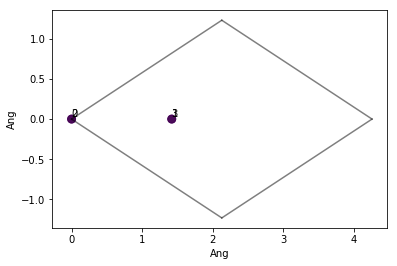

In [0]:
%%time
aa = sisl.geom.graphene().tile(1,0).tile(2,2)

#gnr.tile(reps = 20,axis=1)

print(aa)

plot(aa,atom_indices= True)

print(aa.xyz)


#separating the coordinates into arrays so that we can 3D plot them 

xarray = aa.xyz[:,0]

yarray = aa.xyz[:,1]

zarray = aa.xyz[:,2]




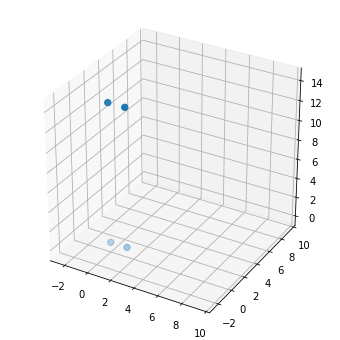

In [0]:
#now we want to plot our grid in 3D

#the scatter plot below shows the positions of the two layers of graphene

fig = plt.figure(figsize= (10,6))
ax = plt.axes(projection='3d')

ax.scatter3D(xarray, yarray, zarray, s = 40)
plt.xlim(-3, 10)
plt.ylim(-3, 10)

plt.gca().set_aspect('equal', adjustable='box') 
plt.draw()

 ## TEST 1
 
 ## NORMAL WAY

In [0]:
#calculation the band structure of bilayer graphene

#we first construct a blank canvas for the Hamiltonian

H = Hamiltonian(aa)

#now we need to set its values 

#we loop the Hamiltonian


"""  
  np.where(H.geom.xyz[idx[2],2] == H.geom.xyz[ia,2], H[io,idx[2]] ,H[io,idx[2]] = -0.4)""" 

#we want the loop to IGNORE the atoms in the same layer

for ia in aa:
  idx, xyz = aa.close(ia, R = [0.1, 1.43, 14.2], ret_xyz = True)
  
  H[ia,idx[0]] = 0
  H[ia,idx[1]] = -2.7
  
  
  #i dont know how I would implement this info
  #print(type(idx[2]))
  print(xyz[2][:,2])
  
  
  for i in range(len(idx[2])):
    
    if xyz[2][i,2] != aa.xyz[ia,2]:
      H[ia,idx[2][i]] = -0.4

  

  
    
print(H)

    
    

[14.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0. ]
[14.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0. ]
[ 0.  14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2
 14.2]
[ 0.  14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2 14.2
 14.2]
Hamiltonian{non-zero: 20, orthogonal: True,
 Spin{unpolarized, kind=f},
 Geometry{na: 4, no: 4,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.01070, maxR: 1.43420,
    Orbital{R: 1.43420, q0: 0.0}
   }: 4,
  },
  maxR: 1.43420,
  SuperCell{volume: 1.4878e+02, nsc: [3 3 1]}
 }
}


In [0]:
band = BandStructure(H, [[0, 0, 0], [0, 0.5, 0],
                         [1/3, 2/3, 0], [0, 0, 0]], 400,
                        [r'$\Gamma$', r'$M$',
                         r'$K$', r'$\Gamma$'])


eigs = band.eigh()

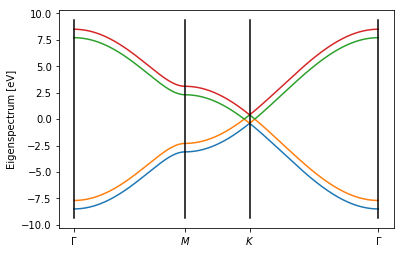

In [0]:
xtick, xtick_label = band.lineartick() #points where the band undergoes changes 
lk = band.lineark() 
plt.plot(lk, eigs)


plt.ylabel('Eigenspectrum [eV]')
plt.gca().xaxis.set_ticks(xtick)
plt.gca().set_xticklabels(xtick_label)

# Also plot x-major lines at the ticks
ymin, ymax = plt.gca().get_ylim()
for tick in xtick:
    plt.plot([tick,tick], [ymin,ymax], 'k')

## Twisted Graphene Hamiltonian 

In order to calculate the Hamiltonian for a system with two layers of graphene, where the top layer is twisted at some angle (wrt to the bottom one). The total Hamiltonian of the system is the following: 

$$ H = H_1 + H_2 + H_{int} $$

$ H_1 $ refers to the Hamiltonian of the bottom layer, $ H_2 $ refers to the Hamiltonian of the top layer, and $H_{int} = \gamma_{int}e^{(r_{ij} - d)\beta}$ is the interaction Hamiltonian between the two layers, where $d$ is the interlayer separation and $\beta = 3$ and $\gamma_1 = 0.39 $ are constants. $\gamma_1$ is the interlayer nearest neighbour hopping integral. $ r_{ij}$ is the distance between atom i in the top layer and atom j in the bottom one. The value of $\beta$ reproduces perfectly the bands calculated with DFT. 

We will consider $r_{ij}$ and $d$ scalars. By choosing this interaction Hamiltonian, we are taking into account that the unit cell is complex and that the distances between atoms are all different. 

We let every atom in the top layers interact with the atoms in the bottom layer within a radius of $3a_0$.

For this, we can utilize Pythagoras Theorem and find that the sphere's radius needs to be 1.85 in order for the H.geom.close function to include all the necessary atom within the desired radius but in the other layer. 

## TEST 2

## EXPONENTIAL HOPPING INTEGRAL

## Moire Patterns


[Moire Pattern Demonstration](http://demonstrations.wolfram.com/MoirePatternsAndCommensurabilityInRotatedGrapheneBilayers/)

Twisted Bilayer Graphene (TBG) is engineered by stacking one graphene layer on top of another at a relative twist angle $\theta$, a procedure which produces a Moiré pattern superlattice potential.

It has recently been experimentally seen that a small relative twist between the layer induces an insulating and superconducting behaviour in the TBG. These behaviours have never been observed in a isolated single graphene sheet. 

It has been observed that TBG exhibits superconducting properties at the magic angle of $\theta = 1.05 °$. This translates into its low energy electronic bands becoming nearly flat at this angle.

Theorists proposed years ago that twisting two graphene layers would result in "Moiré bands" appearing. They arise due to the fact that the twist between layers modulates the tunneling carried out by electrons between the two layers in a periodic way.

The band width increases and decreases with the twist angle between the two layers, vanishing completely at some angles denominated "magic angles". The largest one corresponds to the already mentioned $\theta = 1.05 ° $ 

## Tagging atoms as A and B

(previous band part is unfinished)

Now we will try to tackle the problem in a different way, by tagging atoms (or layers)

In [0]:
ab = sisl.geom.graphene()
print(ab.xyz)
print(ab.cell)

atoma = sisl.Atom('C', tag = 'A')
atomb = sisl.Atom('C', tag = 'B')
geo1 = sisl.Geometry([[0,0,0],[1.42,0,0]], atom = [atoma,atomb])

print(geo1)

#we can define a function that generates a graphene unit cell with the atom tagged

#z1 is the height of layer 1
#z2 is the height of layer 2
#we can define an angle of twist
#x,y,z is number of tiling in that axis
def graphunitcell(z1,z2,angle, x, y ,z):
  geo1 = sisl.Geometry([[0,0,z1], [1.42,0,z1]], atom = [atoma,atomb])
  
  geo1.cell[0,:] = [2.13,1.2297,0]
  geo1.cell[1,:]= [2.13,-1.2297,0]
  geo1.cell[2,:] = [0,0,14.2]
  
  geo1_fi = geo1.tile(x,0).tile(y,1).tile(z,2)
  
  if z2 != z1:
    geo2 = geo1_fi.rotate(angle = angle, v=[0,0,1]).move(v=[0,0,z2-z1]) 
    geofinal = geo1_fi.add(geo2)
    
    return geofinal
  else:
    return geo1
  
  
  
bilayergraphene = graphunitcell(0,1,0,3,3,1)


print(bilayergraphene.xyz)

xarray2 = bilayergraphene.xyz[:,0]

yarray2 = bilayergraphene.xyz[:,1]

zarray2 = bilayergraphene.xyz[:,2]



[[0.   0.   0.  ]
 [1.42 0.   0.  ]]
[[ 2.13        1.22975607  0.        ]
 [ 2.13       -1.22975607  0.        ]
 [ 0.          0.         14.2       ]]
Geometry{na: 2, no: 2,
 Atoms{species: 2,
  Atom{A, Z: 6, mass(au): 12.01070, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 1,
  Atom{B, Z: 6, mass(au): 12.01070, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 1,
 },
 maxR: -1.00000,
 SuperCell{volume: 2.8400e+02, nsc: [1 1 1]}
}
[[ 0.      0.      0.    ]
 [ 1.42    0.      0.    ]
 [ 2.13    1.2297  0.    ]
 [ 3.55    1.2297  0.    ]
 [ 4.26    2.4594  0.    ]
 [ 5.68    2.4594  0.    ]
 [ 2.13   -1.2297  0.    ]
 [ 3.55   -1.2297  0.    ]
 [ 4.26    0.      0.    ]
 [ 5.68    0.      0.    ]
 [ 6.39    1.2297  0.    ]
 [ 7.81    1.2297  0.    ]
 [ 4.26   -2.4594  0.    ]
 [ 5.68   -2.4594  0.    ]
 [ 6.39   -1.2297  0.    ]
 [ 7.81   -1.2297  0.    ]
 [ 8.52    0.      0.    ]
 [ 9.94    0.      0.    ]
 [ 0.      0.      1.    ]
 [ 1.42    0.      1.    ]
 [ 2.13  

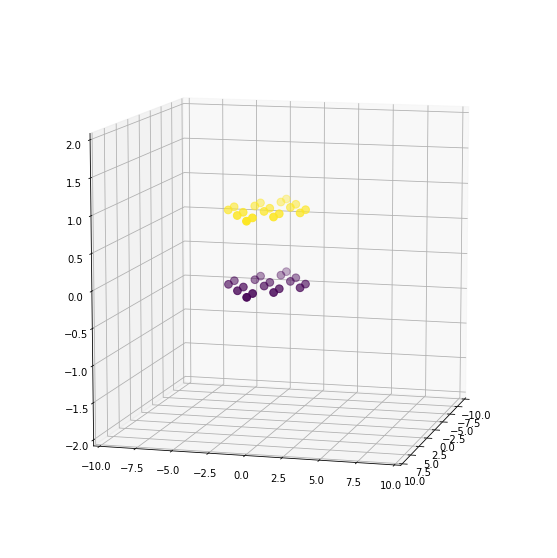

In [0]:
fig = plt.figure(figsize= (10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(xarray2, yarray2, zarray2, c = zarray2, s = 60, )
plt.xlim(-10, 10)
plt.ylim(-10, 10)


plt.gca().set_aspect('equal', adjustable='box') 
ax.view_init(elev=10, azim=15)
ax.set_zlim(-2,2)
        
plt.show()

## Tagging atoms again

## TEST 4

In [0]:




#we can define a function that generates a graphene unit cell with the atom tagged

#z1 is the height of layer 1
#z2 is the height of layer 2
#we can define an angle of twist
#x,y,z is number of tiling in that axis
def graphunitcell(z1,z2,angle, x, y ,z):
  #creating a function that tags graphene
  g = sisl.geom.graphene()
  gtop = sisl.geom.graphene()

#the following way rewrites the atoms species because .atoms is a list of species not of atoms
  g.atoms[0] = sisl.Atom('C', tag = 'A')
  g.atoms[1] = sisl.Atom('C', tag = 'B')
  
  gtop.atoms[0] = sisl.Atom('C', tag = 'A2')
  gtop.atoms[1] = sisl.Atom('C', tag = 'B2')
  
  g1 = g.tile(x,0).tile(y,1).tile(z,2)
#making it bilayer 

  g2 = gtop.tile(x,0).tile(y,1).tile(z,2).rotate(angle = angle, v=[0,0,1], origo = [0,0,z2-z1]).move(v=[0,0,z2-z1])

  gfinal = g1.add(g2)
  
  if z2 != z1:
    
    return gfinal
  
  else:
    return g1

TBG = graphunitcell(0,2,0,1,1,1)

xarray2 = TBG.xyz[:,0]

yarray2 = TBG.xyz[:,1]

zarray2 = TBG.xyz[:,2]



print(TBG)

Geometry{na: 4, no: 4,
 Atoms{species: 5,
  Atom{C, Z: 6, mass(au): 12.01070, maxR: 1.43420,
   Orbital{R: 1.43420, q0: 0.0}
  }: 0,
  Atom{A, Z: 6, mass(au): 12.01070, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 1,
  Atom{B, Z: 6, mass(au): 12.01070, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 1,
  Atom{A2, Z: 6, mass(au): 12.01070, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 1,
  Atom{B2, Z: 6, mass(au): 12.01070, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 1,
 },
 maxR: 1.43420,
 SuperCell{volume: 7.4390e+01, nsc: [3 3 1]}
}


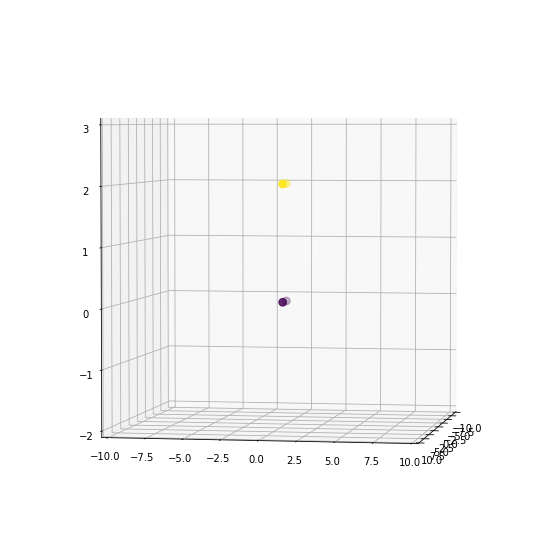

In [0]:
fig = plt.figure(figsize= (10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(xarray2, yarray2, zarray2, c = zarray2, s = 60, )
plt.xlim(-10, 10)
plt.ylim(-10, 10)


plt.gca().set_aspect('equal', adjustable='box') 
ax.view_init(elev=3, azim=10)
ax.set_zlim(-2,3)
        
plt.show()


In [0]:
#initializing the Hamiltonian
#DIFFERENT APPROACH
#TRY THE EXPONENTIAL HOPPING INTEGRAL

Hg2 = Hamiltonian(TBG)

array1 = np.where(TBG.atom.specie == 1) [0]#A
array2 = np.where(TBG.atom.specie == 2) [0]#B
array3 = np.where(TBG.atom.specie == 3) [0]#A' top layer
array4 = np.where(TBG.atom.specie == 4) [0]#B' top layer 


for ia,io in Hg2:
  idx, xyz, rij = Hg2.geom.close(ia, R = [0.1, 1.43], ret_xyz = True, ret_rij = True)
  
  Hg2[io, idx[0]] = 0
  Hg2[io, idx[1]] = -2.7
  
for ia in array1:
  
  index,xyz,rij = Hg2.geom.close(ia, idx = array3, R = [2.0], ret_xyz = True, ret_rij = True)
  
  
  for i in range(len(rij)):
    Hg2[ia,index[0]] = 0.39 * np.exp((rij[0] - 2)*3)
    Hg2[index[0],ia] = 0.39 * np.exp((rij[0] - 2)*3)
   
  
for ia in array2:
  
  index,xyz,rij = Hg2.geom.close(ia, idx = array4, R = [2.0], ret_xyz = True, ret_rij = True)
  
  
  for i in range(len(rij)):
    Hg2[ia,index[0]] = 0.39 * np.exp((rij[0] - 2)*3)
    Hg2[index[0],ia] = 0.39 * np.exp((rij[0] - 2)*3)


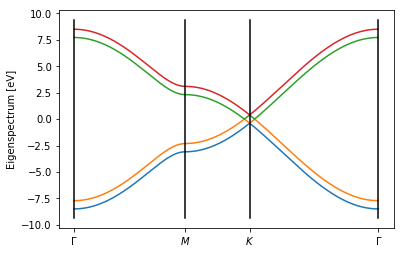

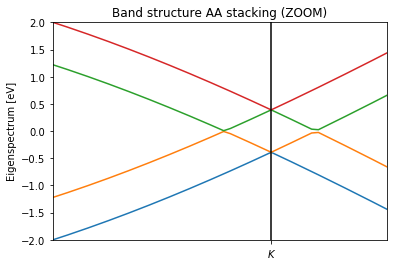

In [0]:
band = BandStructure(Hg2, [[0, 0, 0], [0, 0.5, 0],
                         [1/3, 2/3, 0], [0, 0, 0]], 400,
                        [r'$\Gamma$', r'$M$',
                         r'$K$', r'$\Gamma$'])

eigs = band.eigh()


xtick, xtick_label = band.lineartick() #points where the band undergoes changes 
lk = band.lineark() 
plt.plot(lk, eigs)


plt.ylabel('Eigenspectrum [eV]')
plt.gca().xaxis.set_ticks(xtick)
plt.gca().set_xticklabels(xtick_label)

# Also plot x-major lines at the ticks
ymin, ymax = plt.gca().get_ylim()
for tick in xtick:
    plt.plot([tick,tick], [ymin,ymax], 'k')
    
    
plt.figure()

xtick, xtick_label = band.lineartick() #points where the band undergoes changes 
lk = band.lineark() 
plt.plot(lk, eigs)
plt.title("Band structure AA stacking (ZOOM)")

plt.ylabel('Eigenspectrum [eV]')
plt.gca().xaxis.set_ticks(xtick)
plt.gca().set_xticklabels(xtick_label)

plt.axis([2,2.5,-2,2])

# Also plot x-major lines at the ticks
ymin, ymax = plt.gca().get_ylim()
for tick in xtick:
  plt.plot([tick,tick], [ymin,ymax], 'k')

plt.show()

## TEST 5 

### Tagging atoms of a tiled system

Geometry{na: 36, no: 36,
 Atoms{species: 5,
  Atom{C, Z: 6, mass(au): 12.01070, maxR: 1.43420,
   Orbital{R: 1.43420, q0: 0.0}
  }: 0,
  Atom{A, Z: 6, mass(au): 12.01070, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 9,
  Atom{B, Z: 6, mass(au): 12.01070, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 9,
  Atom{A2, Z: 6, mass(au): 12.01070, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 9,
  Atom{B2, Z: 6, mass(au): 12.01070, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 9,
 },
 maxR: 1.43420,
 SuperCell{volume: 6.6951e+02, nsc: [3 3 1]}
}


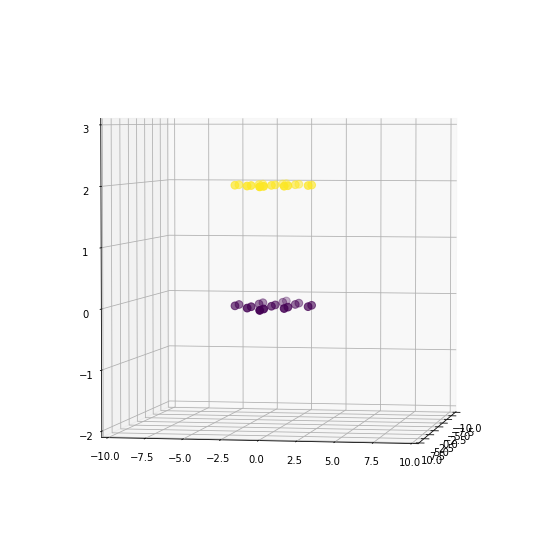

In [0]:
#using the function we designed 

TBG_tiled = graphunitcell(0,2,0,3,3,1)

print(TBG_tiled)

#plotting the structure

xarray_tiled = TBG_tiled.xyz[:,0]

yarray_tiled = TBG_tiled.xyz[:,1]

zarray_tiled = TBG_tiled.xyz[:,2]


fig = plt.figure(figsize= (10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(xarray_tiled, yarray_tiled, zarray_tiled, c = zarray_tiled, s = 60, )
plt.xlim(-10, 10)
plt.ylim(-10, 10)


plt.gca().set_aspect('equal', adjustable='box') 
ax.view_init(elev=3, azim=10)
ax.set_zlim(-2,3)
        
plt.show()

In [0]:
Hg_tiled = Hamiltonian(TBG_tiled)

array1 = np.where(TBG_tiled.atom.specie == 1) [0]
array2 = np.where(TBG_tiled.atom.specie == 2) [0]
array3 = np.where(TBG_tiled.atom.specie == 3) [0]
array4 = np.where(TBG_tiled.atom.specie == 4) [0]


for ia,io in Hg_tiled:
  idx, xyz, rij = Hg_tiled.geom.close(ia, R = [0.1, 1.43], ret_xyz = True, ret_rij = True)
  
  Hg_tiled[io, idx[0]] = 0
  Hg_tiled[io, idx[1]] = -2.7
  
  
for ia in array1:
  
  index,xyz,rij = Hg_tiled.geom.close(ia, idx = array3, R = [2.0], ret_xyz = True, ret_rij = True) 
  if ia <= 10:
    print(index, rij)
  
  for i in range(len(rij)):
    print('were here', 0.039 * np.exp((rij[i] - 2)*3))
    Hg_tiled[ia,index[0]] = 0.39 * np.exp((rij[i] - 2)*3)
    Hg_tiled[index[0],ia] = 0.39 * np.exp((rij[i] - 2)*3)
    
for ia in array2:
  
  index,xyz,rij = Hg_tiled.geom.close(ia, idx = array4, R = [2.0], ret_xyz = True, ret_rij = True) 
  
  for i in range(len(rij)):
    Hg_tiled[ia,index[0]] = 0.39 * np.exp((rij[i] - 2)*3)
    Hg_tiled[index[0],ia] = 0.39 * np.exp((rij[i] - 2)*3)

    
print(np.where(Hg_tiled.Hk().todense()==0.039))
  
#if this last bit is added it looks like straight lines

[18] [2.]
were here 0.039
[20] [2.]
were here 0.039
[22] [2.]
were here 0.039
[24] [2.]
were here 0.039
[26] [2.]
were here 0.039
[28] [2.]
were here 0.039
were here 0.039
were here 0.039
were here 0.039
(array([], dtype=int64), array([], dtype=int64))


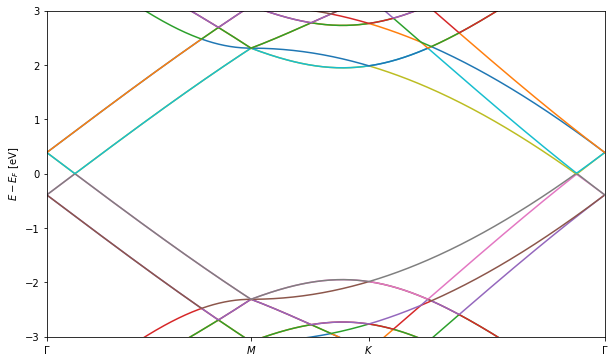

In [0]:
band = BandStructure(Hg_tiled, [[0, 0, 0], [0, 0.5, 0],
                         [1/3, 2/3, 0], [0, 0, 0]], 400,
                        [r'$\Gamma$', r'$M$',
                         r'$K$', r'$\Gamma$'])

bs = band.asarray().eigh()



lk, kt, kl = band.lineark(True)
plt.figure(figsize = (10,6))
plt.xticks(kt, kl)
plt.xlim(0, lk[-1])
plt.ylim([-3, 3])
plt.ylabel('$E-E_F$ [eV]')
for bk in bs.T:
    plt.plot(lk, bk)

### Model for the Hamiltonian of TBG

Describing the behaviour and therefore a model for Twisted Bilayer Graphene is extremely challenging, due to the unit cells in the Moiré pattern becoming infinitely large. We will use a model proposed by [Lin et al.](https://arxiv.org/pdf/1808.03634.pdf), this is a minimum tight-binding model with 3 parameters (inspired by MLG and untwisted BLG). 

They first consider a usual non-twisted bilayer graphene system. They propose that the interlayer hopping integral can be modified if one of the atom from one of the layers is displaced by some distance r. This can be corrected using the following equation

$$ t(r) = Ve^{-(\sqrt{r^2+d_0^2}-d_0)/\lambda}\frac{d_0^2}{r^2+d_0^2} $$

The values for all of these parameters are:

$$ a = 2.46$$ 
$$ d_0 = 3.35 $$
$$ V = 0.39 eV $$
$$ \lambda = 0.27 $$ 

# AB-stacking 


$ \gamma_1 = $ AA' on top of each other

$\gamma_3 = $ BB' BUT NOT on top of each other

$\gamma_4= $ AB' or BA' (not on top of each other)



![texto alternativo](https://i.postimg.cc/HkMQgYzN/abstackinghopping2.png)


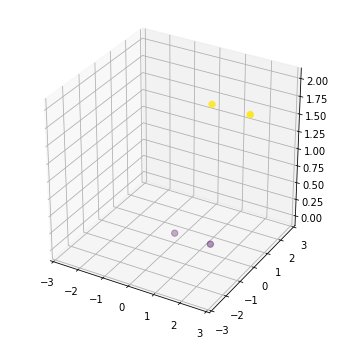

In [0]:
#generating a normal graphene unit cell 
#AB stacking

#we can define a function that generates a graphene unit cell with the atom tagged

#z1 is the height of layer 1
#z2 is the height of layer 2
#we can define an angle of twist
#x,y,z is number of tiling in that axis
def graphunitcell(z1,z2,angle, x, y ,z):
  #creating a function that tags graphene
  g = sisl.geom.graphene()
  gtop = sisl.geom.graphene()
  

#the following way rewrites the atoms species because .atoms is a list of species not of atoms
  g.atoms[0] = sisl.Atom('C', tag = 'B')
  g.atoms[1] = sisl.Atom('C', tag = 'A')
  
  gtop.atoms[0] = sisl.Atom('C', tag = 'A2') #we reverse the order because of AB
  gtop.atoms[1] = sisl.Atom('C', tag = 'B2') #we reverse the order because of AB
  
  g1 = g.tile(x,0).tile(y,1).tile(z,2)
  
#making it bilayer 
#for making it bilayer we just changed the move function attributes

  g2 = gtop.tile(x,0).tile(y,1).tile(z,2).rotate(angle = angle, v=[0,0,1]).move(v=[1.42,0,z2-z1])

  gfinal = g1.add(g2)
  
  if z2 != z1:
    
    return gfinal
  
  else:
    return g1
  

  
ab = graphunitcell(0,2,0,1,1,1)

xarray = ab.xyz[:,0]
yarray = ab.xyz[:,1]
zarray = ab.xyz[:,2]



#now we want to plot our grid in 3D

#the scatter plot below shows the positions of the two layers of graphene

fig = plt.figure(figsize= (10,6))
ax = plt.axes(projection='3d')

ax.scatter3D(xarray, yarray, zarray, c = zarray, s = 40)
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.gca().set_aspect('equal', adjustable='box') 
plt.draw()


## $\gamma_0 $ and $\gamma_1$

intralayer and directly on top of each other couplings

In [0]:

Hab1 = Hamiltonian (ab)


#The order of the atoms species gets reversed
array1 = np.where(ab.atom.specie == 1) [0]#B
array2 = np.where(ab.atom.specie == 2) [0]#A
array3 = np.where(ab.atom.specie == 3) [0]#A' top layer
array4 = np.where(ab.atom.specie == 4) [0]#B' top layer 


#print(Hab.shape)

#INTRALAYER
for ia,io in Hab1:
  idx, xyz, rij = Hab1.geom.close(ia, R = [0.1, 1.43], ret_xyz = True, ret_rij = True)
  
  Hab1[io, idx[0]] = 0
  Hab1[io, idx[1]] = -2.7
  
  
#A and A' DIRECTLY ON TOP OF EACH OTHER GAMMA1  
for ia in array2:
  
  index,xyz,rij = Hab1.geom.close(ia, idx = array3, R = [2.0], ret_xyz = True, ret_rij = True)
  print(index)
  print(rij)
  
  for i in range(len(rij)):
    Hab1[ia,index[0]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
    
    
#A and A' DIRECTLY ON TOP OF EACH OTHER GAMMA1 
#COMPLEX CONJUGATE ELEMENTS
for ia in array3:
  
  index,xyz,rij = Hab1.geom.close(ia, idx = array2, R = [2.0], ret_xyz = True, ret_rij = True)
  
  
  for i in range(len(rij)):
    Hab1[ia,index[0]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))

[2]
[2.]
0.39
0.39


## $\gamma_0 $ and $\gamma_3$

Intralayer and AB' or BA' couplings

In [0]:
#HAMILTONIAN

Hab2 = Hamiltonian (ab)


#The order of the atoms species gets reversed
array1 = np.where(ab.atom.specie == 1) [0]#B
array2 = np.where(ab.atom.specie == 2) [0]#A
array3 = np.where(ab.atom.specie == 3) [0]#A' top layer
array4 = np.where(ab.atom.specie == 4) [0]#B' top layer 


#print(Hab.shape)

#INTRALAYER
for ia,io in Hab2:
  idx, xyz, rij = Hab2.geom.close(ia, R = [0.1, 1.43], ret_xyz = True, ret_rij = True)
  
  Hab2[io, idx[0]] = 0
  Hab2[io, idx[1]] = -2.7
    
   
  
#B and A' GAMMA3
    
for ia in array1:
  
  idx,xyz,rij = Hab2.geom.close(ia, idx = array3, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab2[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))

#B and A' GAMMA3
#COMPLEX CONJUGATE ELEMENTS
    
for ia in array3:
  
  idx,xyz,rij = Hab2.geom.close(ia, idx = array1, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab2[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
 
  #A and B' GAMMA3
    
for ia in array2:
  
  idx,xyz,rij = Hab2.geom.close(ia, idx = array4, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab2[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))

# A and B' GAMMA3
#COMPLEX CONJUGATE ELEMENTS
    
for ia in array4:
  
  idx,xyz,rij = Hab2.geom.close(ia, idx = array2, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab2[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))

[ 2 10 18]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[ 0 20 28]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[ 3 11 19]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[ 1 21 29]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494


## $\gamma_0 $ and $\gamma_4$

In [0]:
#HAMILTONIAN

Hab3 = Hamiltonian (ab)


#The order of the atoms species gets reversed
array1 = np.where(ab.atom.specie == 1) [0]#B
array2 = np.where(ab.atom.specie == 2) [0]#A
array3 = np.where(ab.atom.specie == 3) [0]#A' top layer
array4 = np.where(ab.atom.specie == 4) [0]#B' top layer 


#print(Hab.shape)

#INTRALAYER
for ia,io in Hab3:
  idx, xyz, rij = Hab3.geom.close(ia, R = [0.1, 1.43], ret_xyz = True, ret_rij = True)
  
  Hab3[io, idx[0]] = 0
  Hab3[io, idx[1]] = -2.7
  

    
    
 #B and B' GAMMA4

for ia in array1:
  
  idx,xyz,rij = Hab3.geom.close(ia, idx = array4, R = [1.42,2.7], ret_xyz= True, ret_rij= True)
  print(idx)
  print(rij)
  
  for i in range(len(rij[1])):
    Hab3[ia,idx[1][i]] = 0.04
    print(0.39 * np.exp((2- rij[1][i])/3))
    
#B and B' GAMMA4
#COMPLEX CONJUGATE ELEMENTS    
for ia in array4:
  
  idx,xyz,rij = Hab3.geom.close(ia, idx = array1, R = [1.42,2.7], ret_xyz= True, ret_rij= True)
  print(idx)
  print(rij)
  
  for i in range(len(rij[1])):
    Hab3[ia,idx[1][i]] = 0.04
    print(0.39 * np.exp((2- rij[1][i])/3))

[array([], dtype=int64), array([ 7, 11, 19])]
[array([], dtype=float64), array([2.45283509, 2.45283509, 2.45283509])]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[array([], dtype=int64), array([20, 28, 32])]
[array([], dtype=float64), array([2.45283509, 2.45283509, 2.45283509])]
0.33535903617210494
0.33535903617210494
0.33535903617210494


## $\gamma_0 $ and $\gamma_1$ $\gamma_3$

In [0]:
#HAMILTONIAN

Hab4 = Hamiltonian (ab)


#The order of the atoms species gets reversed
array1 = np.where(ab.atom.specie == 1) [0]#B
array2 = np.where(ab.atom.specie == 2) [0]#A
array3 = np.where(ab.atom.specie == 3) [0]#A' top layer
array4 = np.where(ab.atom.specie == 4) [0]#B' top layer 


#print(Hab.shape)

#INTRALAYER
for ia,io in Hab4:
  idx, xyz, rij = Hab4.geom.close(ia, R = [0.1, 1.43], ret_xyz = True, ret_rij = True)
  
  Hab4[io, idx[0]] = 0
  Hab4[io, idx[1]] = -2.7
  
  
#A and A' DIRECTLY ON TOP OF EACH OTHER GAMMA1  
for ia in array2:
  
  index,xyz,rij = Hab4.geom.close(ia, idx = array3, R = [2.0], ret_xyz = True, ret_rij = True)
  print(index)
  print(rij)
  
  for i in range(len(rij)):
    Hab4[ia,index[0]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
    
    
#A and A' DIRECTLY ON TOP OF EACH OTHER GAMMA1 
#COMPLEX CONJUGATE ELEMENTS
for ia in array3:
  
  index,xyz,rij = Hab4.geom.close(ia, idx = array2, R = [2.0], ret_xyz = True, ret_rij = True)
  
  
  for i in range(len(rij)):
    Hab4[ia,index[0]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
    
   
  
#B and A' GAMMA3
    
for ia in array1:
  
  idx,xyz,rij = Hab4.geom.close(ia, idx = array3, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab4[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))

#B and A' GAMMA3
#COMPLEX CONJUGATE ELEMENTS
    
for ia in array3:
  
  idx,xyz,rij = Hab4.geom.close(ia, idx = array1, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab4[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
 
  #A and B' GAMMA3
    
for ia in array2:
  
  idx,xyz,rij = Hab4.geom.close(ia, idx = array4, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab4[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))

# A and B' GAMMA3
#COMPLEX CONJUGATE ELEMENTS
    
for ia in array4:
  
  idx,xyz,rij = Hab4.geom.close(ia, idx = array2, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab4[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))

[2]
[2.]
0.39
0.39
[ 2 10 18]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[ 0 20 28]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[ 3 11 19]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[ 1 21 29]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494


## ALL the $\gamma$

In [0]:
#HAMILTONIAN

Hab5 = Hamiltonian (ab)


#The order of the atoms species gets reversed
array1 = np.where(ab.atom.specie == 1) [0]#B
array2 = np.where(ab.atom.specie == 2) [0]#A
array3 = np.where(ab.atom.specie == 3) [0]#A' top layer
array4 = np.where(ab.atom.specie == 4) [0]#B' top layer 


#print(Hab.shape)

#INTRALAYER
for ia,io in Hab5:
  idx, xyz, rij = Hab5.geom.close(ia, R = [0.1, 1.43], ret_xyz = True, ret_rij = True)
  
  Hab5[io, idx[0]] = 0
  Hab5[io, idx[1]] = -2.7
  
  
#A and A' DIRECTLY ON TOP OF EACH OTHER GAMMA1  
for ia in array2:
  
  index,xyz,rij = Hab5.geom.close(ia, idx = array3, R = [2.0], ret_xyz = True, ret_rij = True)
  print(index)
  print(rij)
  
  for i in range(len(rij)):
    Hab5[ia,index[0]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
    
    
#A and A' DIRECTLY ON TOP OF EACH OTHER GAMMA1 
#COMPLEX CONJUGATE ELEMENTS
for ia in array3:
  
  index,xyz,rij = Hab5.geom.close(ia, idx = array2, R = [2.0], ret_xyz = True, ret_rij = True)
  
  
  for i in range(len(rij)):
    Hab5[ia,index[0]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
    
   
  
#B and A' GAMMA3
    
for ia in array1:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array3, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab5[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))

#B and A' GAMMA3
#COMPLEX CONJUGATE ELEMENTS
    
for ia in array3:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array1, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab5[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
 
  #A and B' GAMMA3
    
for ia in array2:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array4, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab5[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))

# A and B' GAMMA3
#COMPLEX CONJUGATE ELEMENTS
    
for ia in array4:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array2, R = [2.7], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab5[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
    
    
 #B and B' GAMMA4

for ia in array1:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array4, R = [1.4,2.7], ret_xyz= True, ret_rij= True)
  print(idx)
  print(rij)
  
  for i in range(len(rij[1])):
    Hab5[ia,idx[1][i]] = 0.04
    print(0.39 * np.exp((2- rij[1][i])/3))
    
#B and B' GAMMA4
#COMPLEX CONJUGATE ELEMENTS    
for ia in array4:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array1, R = [1.4,2.7], ret_xyz= True, ret_rij= True)
  print(idx)
  print(rij)
  
  for i in range(len(rij[1])):
    Hab5[ia,idx[1][i]] = 0.04
    print(0.39 * np.exp((2- rij[1][i])/3))

[2]
[2.]
0.39
0.39
[ 2 10 18]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[ 0 20 28]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[ 3 11 19]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[ 1 21 29]
[2.45283509 2.45283509 2.45283509]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[array([], dtype=int64), array([ 7, 11, 19])]
[array([], dtype=float64), array([2.45283509, 2.45283509, 2.45283509])]
0.33535903617210494
0.33535903617210494
0.33535903617210494
[array([], dtype=int64), array([20, 28, 32])]
[array([], dtype=float64), array([2.45283509, 2.45283509, 2.45283509])]
0.33535903617210494
0.33535903617210494
0.33535903617210494


coupling constants $\gamma0$ and $\gamma3$


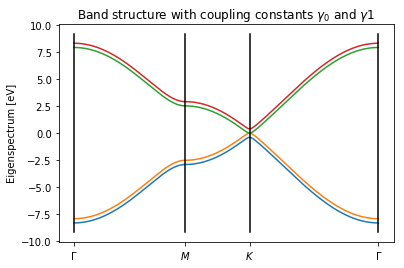

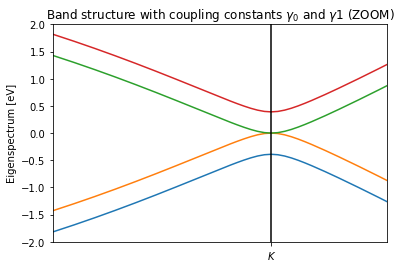

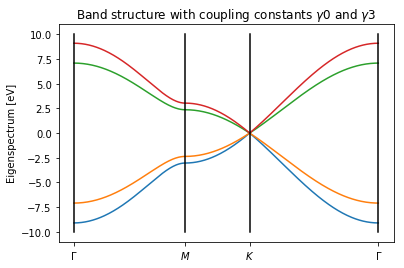

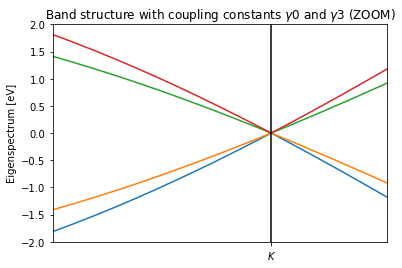

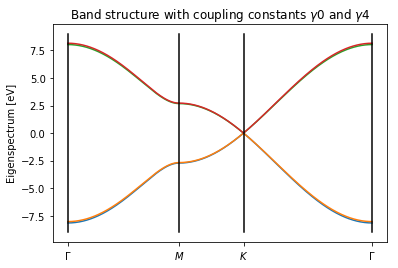

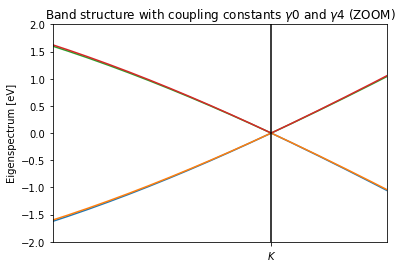

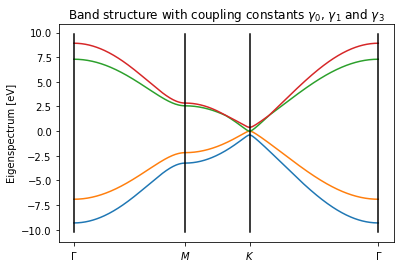

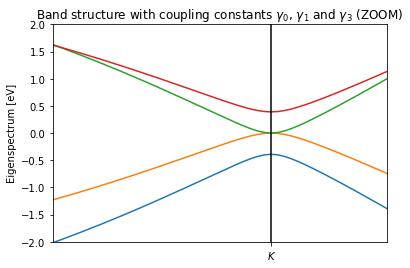

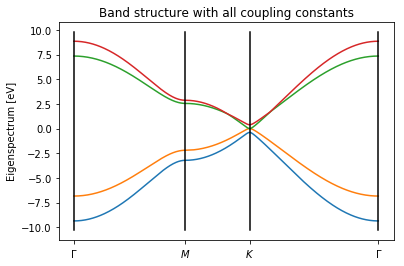

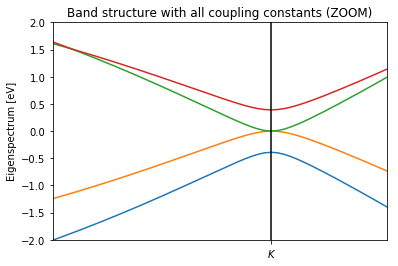

In [0]:
Harray = [Hab1,Hab2,Hab3,Hab4,Hab5]
gamma_array = ["coupling constants $\gamma_0$ and $\gamma1$",
              "coupling constants $\gamma0$ and $\gamma3$",
              "coupling constants $\gamma0$ and $\gamma4$",
              "coupling constants $\gamma_0$, $\gamma_1$ and $\gamma_3$",
              "all coupling constants"]


print(gamma_array[1])


for i in range(0,5):
  plt.figure()
  band = BandStructure(Harray[i], [[0, 0, 0], [0, 0.5, 0],
                           [1/3, 2/3, 0], [0, 0, 0]], 400,
                          [r'$\Gamma$', r'$M$',
                           r'$K$', r'$\Gamma$'])

  eigs = band.eigh()


  xtick, xtick_label = band.lineartick() #points where the band undergoes changes 
  lk = band.lineark() 
  plt.plot(lk, eigs)
  plt.title("Band structure with " + gamma_array[i])

  plt.ylabel('Eigenspectrum [eV]')
  plt.gca().xaxis.set_ticks(xtick)
  plt.gca().set_xticklabels(xtick_label)

  # Also plot x-major lines at the ticks
  ymin, ymax = plt.gca().get_ylim()
  for tick in xtick:
      plt.plot([tick,tick], [ymin,ymax], 'k')
  plt.savefig("plot of AB stacked with " + gamma_array[i] + ".pdf")

  plt.show()

  #ZOOMED IN 
  plt.figure()

  xtick, xtick_label = band.lineartick() #points where the band undergoes changes 
  lk = band.lineark() 
  plt.plot(lk, eigs)
  plt.title("Band structure with " + gamma_array[i] + " (ZOOM)")

  plt.ylabel('Eigenspectrum [eV]')
  plt.gca().xaxis.set_ticks(xtick)
  plt.gca().set_xticklabels(xtick_label)

  plt.axis([2,2.5,-2,2])

  # Also plot x-major lines at the ticks
  ymin, ymax = plt.gca().get_ylim()
  for tick in xtick:
      plt.plot([tick,tick], [ymin,ymax], 'k')
  plt.savefig( "zoomed plot of AB stacked with " + gamma_array[i] + ".pdf")
  plt.show()
        

  
  

## How do each of the coupling constants affect the band structure of an AB stacked graphene system?

### $\gamma_0 $& $\gamma1 $

It is obvious that the influence of this two coupling constants is the characteristis grpahene shape, along with a crossing of the bands slightly different than AA stacked graphene. 

### Addition of $\gamma_3$

The addition of this coupling constant produces the opening of the bands in the edges of the eigenspectrum. Furthermore, it also modifies the symmetry of the band structure

### Addition of $\gamma_4$ 

The implementation of this coupling constants does not have a big influence in the overall shape of the bands. However, in the zoomed in plot, it can be observed that a very minimal band gap opens. 

# COMPARISON WITH DFT DATA
Now we can compare the obtained data with Tight Binding to DFT calculations.

In [0]:
#loading the DFT data
from google.colab import files
uploaded = files.upload()




In [0]:
k, E = np.genfromtxt("bands4.txt", usecols = (0,1),delimiter = ',', unpack= True)
print(k)
print(E)

k= k[~np.isnan(k)]
print(k)

E = E[~np.isnan(E)]
print(E)

#the function took a wrong value for E
print(E.shape)
print(k.shape)


#we remove that first wrong value
E = np.delete(E,0)

print(E)

def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 
  
# How many elements each 
# list should have 
n = 601
  
karray = list(divide_chunks(k, n)) 
print (karray)

Earray = list(divide_chunks(E,n))

print(Earray)


[     nan      nan      nan ... 2.111751 2.116232 2.120714]
[   nan    nan    nan ... 6.6803 6.6791 6.6787]
[0.       0.003881 0.007762 ... 2.111751 2.116232 2.120714]
[ -5.     -25.6532 -25.653  ...   6.6803   6.6791   6.6787]
(9617,)
(9616,)
[-25.6532 -25.653  -25.6526 ...   6.6803   6.6791   6.6787]
[array([0.      , 0.003881, 0.007762, 0.011644, 0.015525, 0.019406,
       0.023287, 0.027168, 0.03105 , 0.034931, 0.038812, 0.042693,
       0.046574, 0.050456, 0.054337, 0.058218, 0.062099, 0.06598 ,
       0.069862, 0.073743, 0.077624, 0.081505, 0.085386, 0.089268,
       0.093149, 0.09703 , 0.100911, 0.104792, 0.108674, 0.112555,
       0.116436, 0.120317, 0.124198, 0.12808 , 0.131961, 0.135842,
       0.139723, 0.143604, 0.147486, 0.151367, 0.155248, 0.159129,
       0.16301 , 0.166892, 0.170773, 0.174654, 0.178535, 0.182416,
       0.186298, 0.190179, 0.19406 , 0.197941, 0.201822, 0.205704,
       0.209585, 0.213466, 0.217347, 0.221228, 0.22511 , 0.228991,
       0.232872, 0.236753

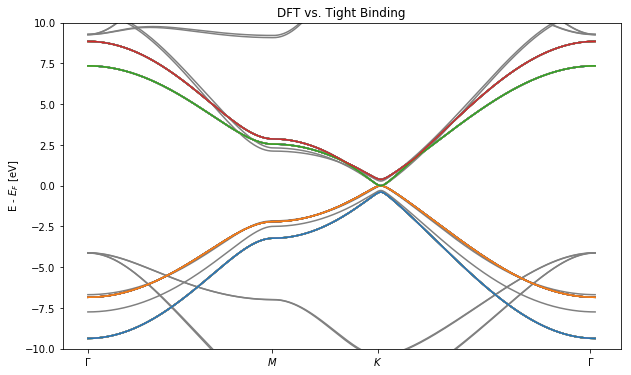

In [0]:
#8.5347

plt.figure(figsize=(10,6))

#making the x axis from 0 to 1
#doing E -EF

for i in range(len(karray)):
  plt.plot(karray[i]/2.120714,Earray[i]+ 5.8109 , c = 'grey')
  plt.ylim(-10,10)
  band = BandStructure(Hab5, [[0, 0, 0], [0, 0.5, 0],
                             [1/3, 2/3, 0], [0, 0, 0]], 400,
                            [r'$\Gamma$', r'$M$',
                             r'$K$', r'$\Gamma$'])

  eigs = band.eigh() 
  lk = band.lineark() 
  plt.plot(lk/4.02957312, eigs)
  plt.title("DFT vs. Tight Binding")
  plt.ylabel('E - $E_F$ [eV]')
  plt.gca().xaxis.set_ticks(xtick/4.0687)
  plt.gca().set_xticklabels(xtick_label)

plt.show()
 

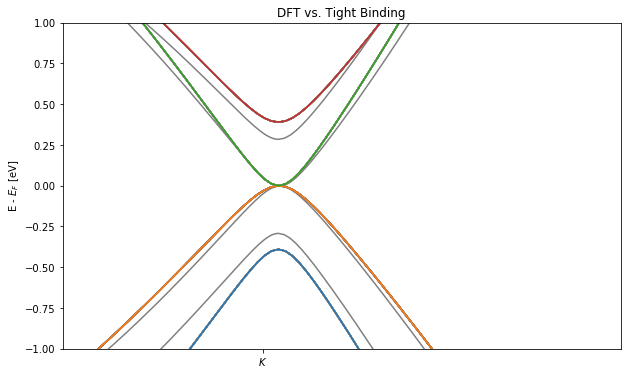

In [0]:
#8.5347

plt.figure(figsize=(10,6))

#making the x axis from 0 to 1
#doing E -EF

for i in range(len(karray)):
  plt.plot(karray[i]/2.120714,Earray[i]+ 5.8109 , c = 'grey')

  band = BandStructure(Hab5, [[0, 0, 0], [0, 0.5, 0],
                             [1/3, 2/3, 0], [0, 0, 0]], 400,
                            [r'$\Gamma$', r'$M$',
                             r'$K$', r'$\Gamma$'])

  eigs = band.eigh() 
  lk = band.lineark() 
  plt.plot(lk/4.02957312, eigs)
  plt.title("DFT vs. Tight Binding")
  plt.ylabel('E - $E_F$ [eV]')
  plt.gca().xaxis.set_ticks(xtick/4.0687)
  plt.gca().set_xticklabels(xtick_label)

  
plt.ylim(-1,1)
plt.xlim(0.5,0.7)
plt.show()

# TWISTED BILAYER GRAPHENE

From [Lopes dos Santos et al.](https://github.com/dipc-cc/internship2019/blob/master/references/LopesDosSantosJEtAl_GrapheneBilayerWithATwistElectronicStructure_PRL2007.pdf), we can see that the allowed rotations (the ones that have a commesurate system as a result) correspond to the following formula:

$$cos\theta_i = \frac{3i^2 + 3i +1/2}{3i^2 + 3i +1} $$

where $i = 0,1,2...$

However, $ i = 0$ corresponds to a non rotated AA stacked bilayer graphene system. For $ i = 1$ this gives an angle of $\theta = 21.78$. The new superlattice vectors are $t_1 = ia_1 + (i +1)a_2$ and $t_2 = -(i+1)a_1 + (2i + 1)a_2$

Mathematically, in a twisted system that results in Moiré patterns, the lattice is strictly periodical only for a set of angles (that follow the relation above), and these give commesurate structures. We define commesurate as a structure were the lattice registration order is perfectly recovered int a finite distance. However, the periodicity of the different angles varies greatly. For example, $\theta = 5.08$ has N = 508 in the unit cell, and $\theta = 0.99$ has N = 13468.


For simplicity, we consider rotations of the top layer about a site occupied by a B' atom (directly opposite to an A atom). We obtain a commesurate structure ( a periodic structure) if a B' atom is moved by the rotation to a position formely occupied by a B'. For example, the famous "magic angle TBG" is more or less an incommesurate material (since its periodicity becomes 13 nm )

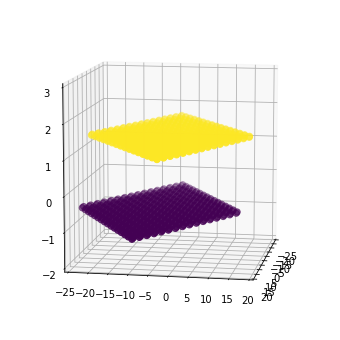

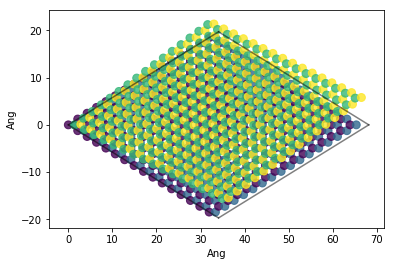

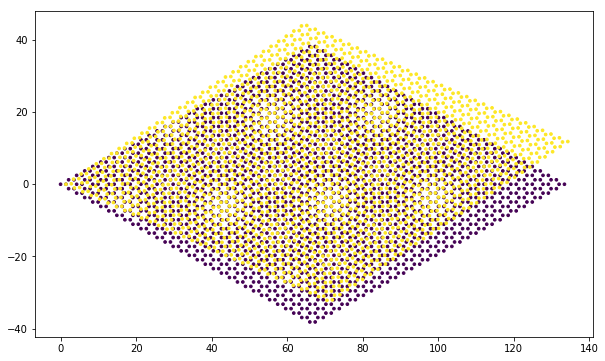

(-40, 40)

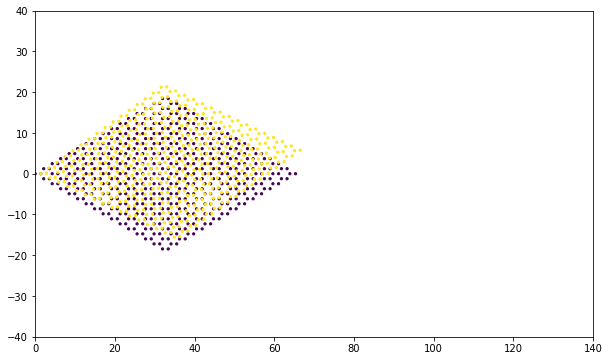

In [0]:
#angle 5.08

tbg1 = graphunitcell(0,2,5.08,16,16,1)

tbg1_tiled = graphunitcell(0,2,5.08,32,32,1)

xarray = tbg1.xyz[:,0]
yarray = tbg1.xyz[:,1]
zarray = tbg1.xyz[:,2]

xarray2 = tbg1_tiled.xyz[:,0]
yarray2 = tbg1_tiled.xyz[:,1]
zarray2 = tbg1_tiled.xyz[:,2]

#now we want to plot our grid in 3D

#the scatter plot below shows the positions of the two layers of graphene

fig = plt.figure(figsize= (10,6))
ax = plt.axes(projection='3d')

ax.scatter3D(xarray, yarray, zarray, c = zarray, s = 40)
plt.xlim(-25, 20)
plt.ylim(-25, 20)

plt.gca().set_aspect('equal', adjustable='box') 
ax.view_init(elev=10, azim=10)
ax.set_zlim(-2,3)

plt.show()

plot(tbg1)

plt.figure(figsize=(10,6))
plt.scatter(xarray2,yarray2, c =zarray2, s = 7)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(xarray,yarray, c =zarray, s= 5)
plt.xlim(0,140)
plt.ylim(-40,40)
#plot(tbg1_tiled)



In [0]:
%%time
#HAMILTONIAN

Hab5 = Hamiltonian(tbg1)


#The order of the atoms species gets reversed
array1 = np.where(tbg1.atom.specie == 1) [0]#B
array2 = np.where(tbg1.atom.specie == 2) [0]#A
array3 = np.where(tbg1.atom.specie == 3) [0]#A' top layer
array4 = np.where(tbg1.atom.specie == 4) [0]#B' top layer 




#print(Hab.shape)

#INTRALAYER
for ia,io in Hab5:
  idx, xyz, rij = Hab5.geom.close(ia, R = [0.1, 1.43], ret_xyz = True, ret_rij = True)
  
  Hab5[io, idx[0]] = 0
  Hab5[io, idx[1]] = -2.7
  
  
#A and A' DIRECTLY ON TOP OF EACH OTHER GAMMA1  
for ia in array2:
  
  index,xyz,rij = Hab5.geom.close(ia, idx = array3, R = [5], ret_xyz = True, ret_rij = True)
  print(index)
  print(rij)
  
  for i in range(len(rij)):
    Hab5[ia,index[0]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
    
    
#A and A' DIRECTLY ON TOP OF EACH OTHER GAMMA1 
#COMPLEX CONJUGATE ELEMENTS
for ia in array3:
  
  index,xyz,rij = Hab5.geom.close(ia, idx = array2, R = [5], ret_xyz = True, ret_rij = True)
  
  
  for i in range(len(rij)):
    Hab5[ia,index[0]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
    
   
  
#B and A' GAMMA3
    
for ia in array1:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array3, R = [8], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab5[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))

#B and A' GAMMA3
#COMPLEX CONJUGATE ELEMENTS
    
for ia in array3:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array1, R = [8], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab5[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
 
  #A and B' GAMMA3
    
for ia in array2:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array4, R = [8], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab5[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))

# A and B' GAMMA3
#COMPLEX CONJUGATE ELEMENTS
    
for ia in array4:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array2, R = [8], ret_xyz = True, ret_rij = True)
  print(idx)
  print(rij)
  
  for i in range(len(rij)):
    Hab5[ia,idx[i]] = 0.39 * np.exp((2- rij[i])/3)
    print(0.39 * np.exp((2- rij[i])/3))
    
    
 #B and B' GAMMA4

for ia in array1:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array4, R = [1.42,8], ret_xyz= True, ret_rij= True)
  print(idx)
  print(rij)
  
  for i in range(len(rij[1])):
    Hab5[ia,idx[1][i]] = 0.04
    print(0.39 * np.exp((2- rij[1][i])/3))
    
#B and B' GAMMA4
#COMPLEX CONJUGATE ELEMENTS    
for ia in array4:
  
  idx,xyz,rij = Hab5.geom.close(ia, idx = array1, R = [1.42,8], ret_xyz= True, ret_rij= True)
  print(idx)
  print(rij)
  
  for i in range(len(rij[1])):
    Hab5[ia,idx[1][i]] = 0.04
    print(0.39 * np.exp((2- rij[1][i])/3))
    
print(Hab5)

[ 512  514  544  546 3040 4638 4668 4670 4700 4702 4730 4732 4734]
[2.         3.17004732 3.17004732 4.70612367 4.63190057 4.63190057
 4.28120801 2.64399236 3.1486719  2.15064833 4.99359328 3.68753677
 3.78923223]
0.39
0.26404801625731356
0.26404801625731356
0.15823883659555887
0.16220266114690957
0.16220266114690932
0.18231647812930557
0.3146568311039554
0.26593611374983644
0.37089931134735393
0.1437797064159852
0.22221257836597658
0.2148061501787038
[ 512  514  516  544  546  548  576 3040 3042 4670 4702 4732 4734]
[3.17004732 2.01184545 3.18500301 3.02410516 3.0319522  4.61937834
 4.50994724 4.47136261 4.81314518 4.34717599 3.0950515  4.86309293
 3.51555806]
0.2640480162573136
0.38846312827181234
0.2627349514586795
0.2772108342601644
0.2764866873464003
0.16288112273219565
0.16893223530895193
0.17111899712753406
0.15269335276750193
0.17835121843191515
0.27073204645488186
0.1501721689112195
0.23532339537030725
[ 514  516  518  544  546  548  550  576  578  580 3042 3044 4734]
[3.18500

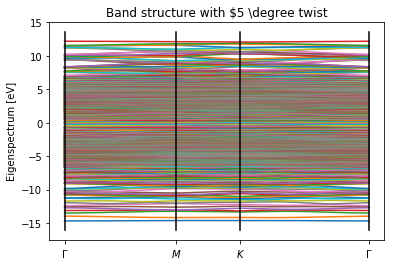

CPU times: user 5min 56s, sys: 32.3 s, total: 6min 29s
Wall time: 3min 17s


In [0]:
#ALL BANDS

%%time
plt.figure()
band = BandStructure(Hab5, [[0, 0, 0], [0, 0.5, 0],
                         [1/3, 2/3, 0], [0, 0, 0]], 400,
                        [r'$\Gamma$', r'$M$',
                         r'$K$', r'$\Gamma$'])

eigs = band.eigh()


xtick, xtick_label = band.lineartick() #points where the band undergoes changes 
lk = band.lineark() 
plt.plot(lk, eigs)
plt.title("Band structure with $5 \degree twist")

plt.ylabel('Eigenspectrum [eV]')
plt.gca().xaxis.set_ticks(xtick)
plt.gca().set_xticklabels(xtick_label)

# Also plot x-major lines at the ticks
ymin, ymax = plt.gca().get_ylim()
for tick in xtick:
    plt.plot([tick,tick], [ymin,ymax], 'k')


plt.show()

Text(0.5, 1.0, 'Time to calculate Hamiltonian vs unit cell size')

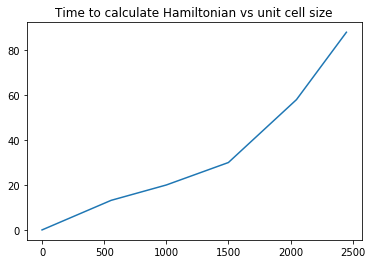

In [0]:
#TIME TAKEN TO CALCULATE HAMILTONIAN FOR DIFF SIZED UNIT CELLS
arraytime = (0,13.162, 20, 30, 58, 88) 
arrayN = (0,556, 1000, 1500, 32*32*2, 35*35*2 )

plt.plot(arrayN, arraytime)
plt.title("Time to calculate Hamiltonian vs unit cell size")

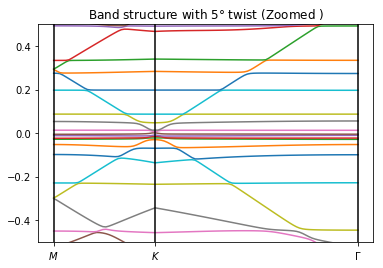

CPU times: user 1min 24s, sys: 8.24 s, total: 1min 32s
Wall time: 47.3 s


In [0]:
##try isolating some bands 
##important ones will be the ones that meet at the K point


%%time
plt.figure()
band = BandStructure(Hab5, [[0, 0.5, 0],
                         [1/3, 2/3, 0], [0, 0, 0]], 100,
                        [ r'$M$',
                         r'$K$', r'$\Gamma$'])
eigs = band.eigh()

xtick, xtick_label = band.lineartick() #points where the band undergoes changes 
lk = band.lineark() 
plt.plot(lk, eigs)
plt.title("Band structure with $5 \degree$ twist ")
plt.ylim(-0.5,0.5)


plt.gca().xaxis.set_ticks(xtick)
plt.gca().set_xticklabels(xtick_label)

# Also plot x-major lines at the ticks
ymin, ymax = plt.gca().get_ylim()
for tick in xtick:
    plt.plot([tick,tick], [ymin,ymax], 'k')

plt.show()



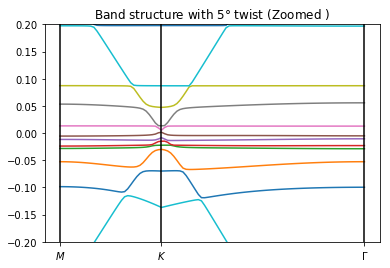

CPU times: user 1min 25s, sys: 8.13 s, total: 1min 34s
Wall time: 48 s


In [0]:
##try isolating some bands 
##important ones will be the ones that meet at the K point


%%time
plt.figure()
band = BandStructure(Hab5, [[0, 0.5, 0],
                         [1/3, 2/3, 0], [0, 0, 0]], 100,
                        [ r'$M$',
                         r'$K$', r'$\Gamma$'])
eigs = band.eigh()

xtick, xtick_label = band.lineartick() #points where the band undergoes changes 
lk = band.lineark() 
plt.plot(lk, eigs)
plt.title("Band structure with $5 \degree$ twist (Zoomed )")
plt.ylim(-0.2,0.2)


plt.gca().xaxis.set_ticks(xtick)
plt.gca().set_xticklabels(xtick_label)

# Also plot x-major lines at the ticks
ymin, ymax = plt.gca().get_ylim()
for tick in xtick:
    plt.plot([tick,tick], [ymin,ymax], 'k')

plt.show()


## Mini Brillouin Zones 

Using the same code we have used so far for the twisted bilayer system, we will try implementing mini brillouin zones, defined by $\delta K = K \theta$. 

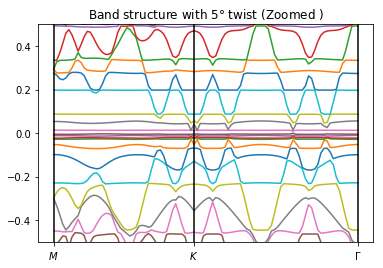

CPU times: user 1min 27s, sys: 8.2 s, total: 1min 36s
Wall time: 49 s


In [0]:

%%time
plt.figure()
band = BandStructure(Hab5, [[0, 0.5, 0],
                         [1/3 * 5.08, 2/3* 5.08, 0], [0, 0, 0]], 100,
                        [ r'$M$',
                         r'$K$', r'$\Gamma$'])
eigs = band.eigh()

xtick, xtick_label = band.lineartick() #points where the band undergoes changes 
lk = band.lineark() 
plt.plot(lk, eigs)
plt.title("Band structure with $5 \degree$ twist (Zoomed )")
plt.ylim(-0.5,0.5)


plt.gca().xaxis.set_ticks(xtick)
plt.gca().set_xticklabels(xtick_label)

# Also plot x-major lines at the ticks
ymin, ymax = plt.gca().get_ylim()
for tick in xtick:
    plt.plot([tick,tick], [ymin,ymax], 'k')

plt.show()